In [6]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time
import matplotlib.pyplot as plt
from itertools import product
from loguru import logger

from carbon.estimate import estimate_carbon_footprint
from carbon.llm import estimate_raw

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Structured Outputs with response_format: {type: "json_schema", ...} are supported for the following models:
models = ['gpt-4o-2024-08-06', 'gpt-4o-mini-2024-07-18']

In [8]:
# From Berners-Lee, M. (2022). *The carbon footprint of everything* (2nd ed.). Greystone Books.

data = [
    ("a disposable diaper", "United States", 0.13),
    ("a roll of toilet paper", "United States", 0.73),
    ("a pint of milk", "United States", 0.9),
    ("a paperback book", "United States", 1),
    ("a night in a hotel", "United States", 75),
    ("a week’s food shopping", "United States", 81),    
]

In [40]:
results = []
for model, (item, country, expected) in product(models, data):
    logger.info(f"Estimating carbon footprint for {item} in {country} using {model} model")
    # using the raw estimate
    start_time = time.time()
    result_raw, cost = estimate_raw(item, country, model=model)
    end_time = time.time()
    results.append({
        "model": model,
        "item": item,
        "country": country,
        "predicted": result_raw.carbon_footprint,
        "expected": expected,
        "time": end_time - start_time,
    })

    logger.info(f"Estimating carbon footprint for {item} in {country} using {model}_carbon model")
    # using our carbon footprint estimate
    start_time = time.time()
    result, cost = estimate_carbon_footprint(item, country, model=model)
    end_time = time.time()
    results.append({
        "model": f"{model}_carbonada",
        "item": item,
        "country": country,
        "predicted": result.carbon_footprint,
        "expected": expected,
        "time": end_time - start_time,
    })

2024-08-24 10:26:32.598 | INFO     | __main__:<module>:3 - Estimating carbon footprint for a disposable diaper in United States using gpt-4o-2024-08-06 model
2024-08-24 10:26:36.313 | ERROR    | carbon.llm:estimate_raw:72 - An error occurred while querying the OpenAI API: 'dict' object is not callable


0


AttributeError: 'NoneType' object has no attribute 'carbon_footprint'

In [23]:
df = pd.DataFrame(results)
df.to_csv('../data/processed/small-eval.csv', index=False)
df.head()

,model,item,country,predicted,expected,time
0,gpt-4o-2024-08-06,a disposable diaper,United States,0.250000,0.13,2.601988
1,gpt-4o-2024-08-06_carbonada,a disposable diaper,United States,0.159003,0.13,6.061638
2,gpt-4o-2024-08-06,a roll of toilet paper,United States,0.500000,0.73,2.105588
3,gpt-4o-2024-08-06_carbonada,a roll of toilet paper,United States,1.217187,0.73,7.154812
4,gpt-4o-2024-08-06,a pint of milk,United States,0.500000,0.90,1.971276


In [24]:
# Calculate MAE for each prediction
df['mae'] = abs(df['predicted'] - df['expected'])
df['mape'] = abs((df['predicted'] - df['expected']) / df['expected']) * 100

# Group by model to calculate the average MAE and time for each model
model_comparison = df.groupby('model').agg(
    average_mae=('mae', 'mean'),
    average_mape=('mape', 'mean'),
    average_time=('time', 'mean')
).reset_index()



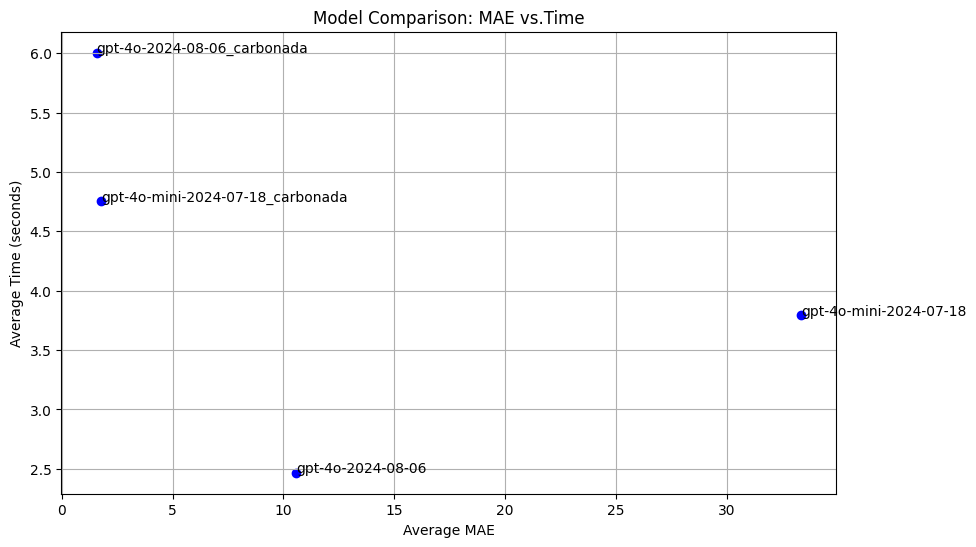

In [25]:
# Plotting the comparison
plt.figure(figsize=(10, 6))
plt.scatter(model_comparison['average_mae'], model_comparison['average_time'], color='blue')

# Annotate points with model names
for i in range(len(model_comparison)):
    plt.text(model_comparison['average_mae'][i], model_comparison['average_time'][i], model_comparison['model'][i])

plt.xlabel('Average MAE')
plt.ylabel('Average Time (seconds)')
plt.title('Model Comparison: MAE vs.Time')
plt.grid(True)
plt.savefig('../reports/figures/model_comparison_mae.png')
plt.show()

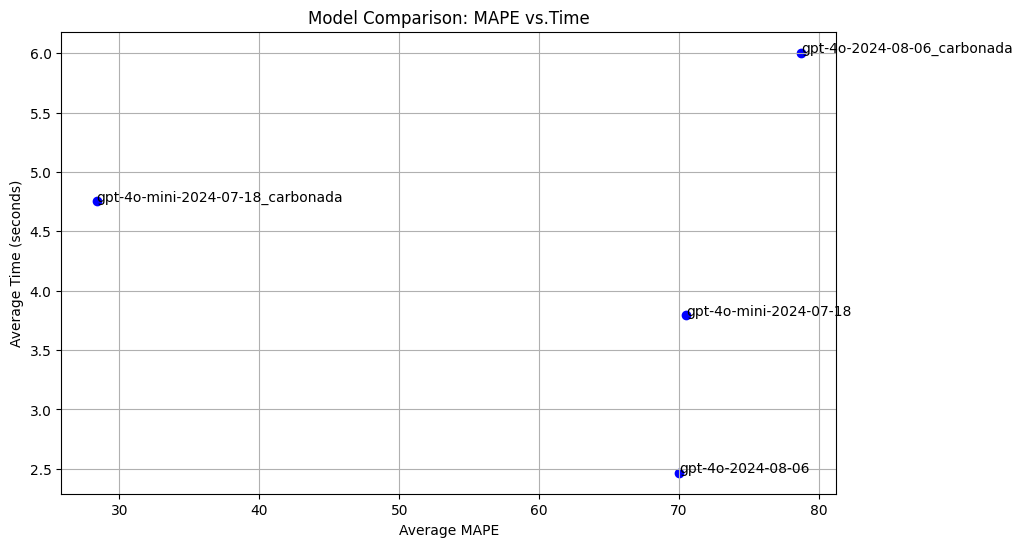

In [26]:
# Plotting the comparison
plt.figure(figsize=(10, 6))
plt.scatter(model_comparison['average_mape'], model_comparison['average_time'], color='blue')

# Annotate points with model names
for i in range(len(model_comparison)):
    plt.text(model_comparison['average_mape'][i], model_comparison['average_time'][i], model_comparison['model'][i])

plt.xlabel('Average MAPE')
plt.ylabel('Average Time (seconds)')
plt.title('Model Comparison: MAPE vs.Time')
plt.grid(True)
plt.savefig('../reports/figures/model_comparison_mape.png')
plt.show()

In [27]:
df_sorted = df.sort_values(by=['item', 'mae'])

# Assign a rank to each model within each item group based on MAE
df_sorted['mae_rank'] = df_sorted.groupby('item')['mae'].rank(method='min')

# Display the ranked DataFrame
df_sorted.head()

,model,item,country,predicted,expected,time,mae,mape,mae_rank
1,gpt-4o-2024-08-06_carbonada,a disposable diaper,United States,0.159003,0.13,6.061638,0.029003,22.310018,1.0
12,gpt-4o-mini-2024-07-18,a disposable diaper,United States,0.200000,0.13,7.481649,0.070000,53.846154,2.0
13,gpt-4o-mini-2024-07-18_carbonada,a disposable diaper,United States,0.222604,0.13,4.430918,0.092604,71.234025,3.0
0,gpt-4o-2024-08-06,a disposable diaper,United States,0.250000,0.13,2.601988,0.120000,92.307692,4.0
9,gpt-4o-2024-08-06_carbonada,a night in a hotel,United States,70.818803,75.00,7.036404,4.181197,5.574930,1.0


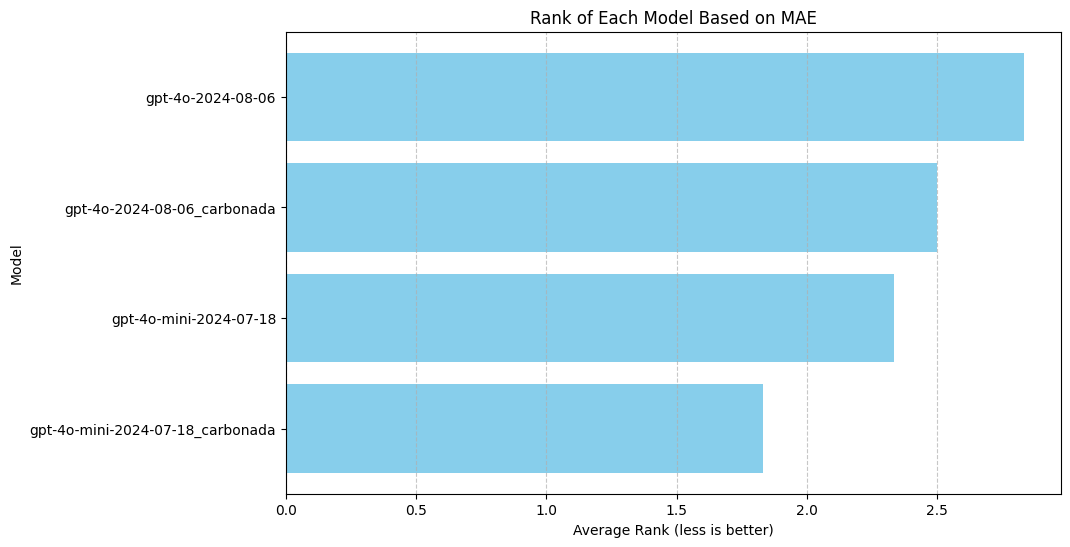

In [28]:
average_rank = df_sorted.groupby('model')['mae_rank'].mean().reset_index()

# Sort models by average rank for better visualization
average_rank = average_rank.sort_values(by='mae_rank')

# Plotting the average ranks
plt.figure(figsize=(10, 6))
plt.barh(average_rank['model'], average_rank['mae_rank'], color='skyblue')
plt.xlabel('Average Rank (less is better)')
plt.ylabel('Model')
plt.title('Rank of Each Model Based on MAE')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig('../reports/figures/model_ranking_mae.png')
plt.show()